In [1]:
import numpy as np
import pandas as pd
import math
from scipy.stats import loguniform
from statistics import mean
from scipy import stats
import seaborn as sns
#import scikit_posthocs
import warnings 
import sklearn 

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report,f1_score
from sklearn.impute import SimpleImputer 
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,cross_val_score,StratifiedKFold,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
#import xgboost as xgb
#from scikit_posthocs import posthoc_nemenyi_friedman

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('heart.csv')
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [3]:
df.shape

(918, 12)

In [4]:
a=df.dtypes
a

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

In [5]:
df.describe()
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


In [6]:
#from the above there is no datatype object that condradicts with the above description

# we splitted the dataset based on feature type=categorical and numeric. 
allFeatures=df.columns[0:len(df.columns) - 1]
catFeatures=[]
for i in range((len(df.columns)-1)):
    if df.dtypes[i]=='O':
        print(i)
        catFeatures.append(i)
catFeatures.append(5) #fasting bs is categorical 1: if FastingBS > 120 mg/dl, 0: otherwise

catFeatures=df.columns[catFeatures]
print(catFeatures)

numFeatures= [i for i in allFeatures if not(i in catFeatures)]
print(allFeatures)

1
2
6
8
10
Index(['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope',
       'FastingBS'],
      dtype='object')
Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope'],
      dtype='object')


In [7]:
df[numFeatures].describe()
#get rid of min resting bp or data points that are insignificant.

,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,136.809368,0.887364
std,9.432617,18.514154,109.384145,25.460334,1.066570
min,28.000000,0.000000,0.000000,60.000000,-2.600000
25%,47.000000,120.000000,173.250000,120.000000,0.000000
50%,54.000000,130.000000,223.000000,138.000000,0.600000
75%,60.000000,140.000000,267.000000,156.000000,1.500000
max,77.000000,200.000000,603.000000,202.000000,6.200000


In [8]:
s=0
c= np.where(df['RestingBP']==0)
print(c[0])
df.iloc[449]

[449]


Age                   55
Sex                    M
ChestPainType        NAP
RestingBP              0
Cholesterol            0
FastingBS              0
RestingECG        Normal
MaxHR                155
ExerciseAngina         N
Oldpeak              1.5
ST_Slope            Flat
HeartDisease           1
Name: 449, dtype: object

In [9]:
df=df.drop(index=449,axis=0) #removed this index because it has resting BP. and Cholestrol zero


In [10]:
df=df.reset_index()
df=df.drop(['index'],axis=1)
df

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
912,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
913,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
914,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
915,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'RestingBP'}>],
       [<AxesSubplot:title={'center':'Cholesterol'}>,
        <AxesSubplot:title={'center':'MaxHR'}>],
       [<AxesSubplot:title={'center':'Oldpeak'}>, <AxesSubplot:>]],
      dtype=object)

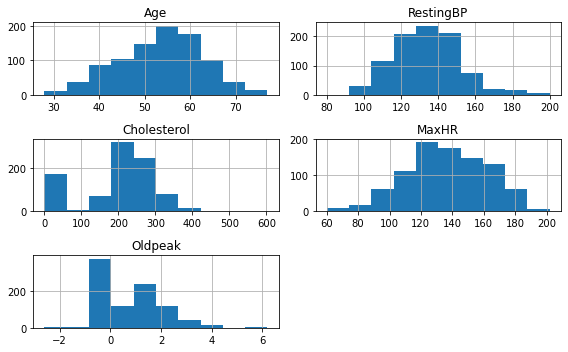

In [11]:
plt.rcParams["figure.figsize"] = [8, 5]
plt.rcParams["figure.autolayout"] = True
df[numFeatures].hist()


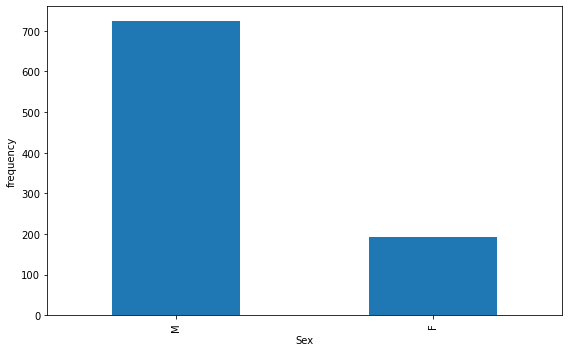

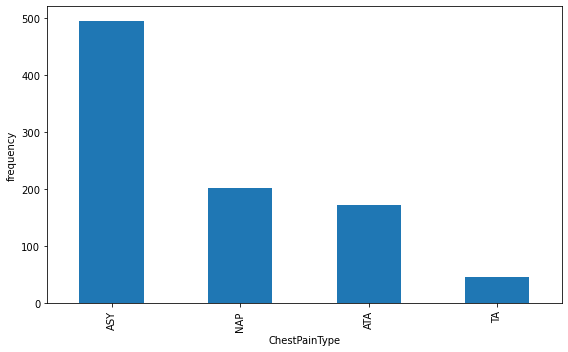

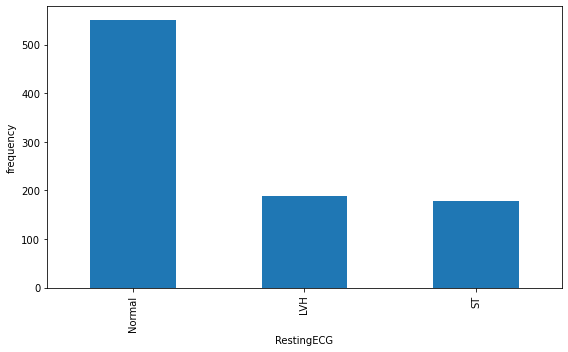

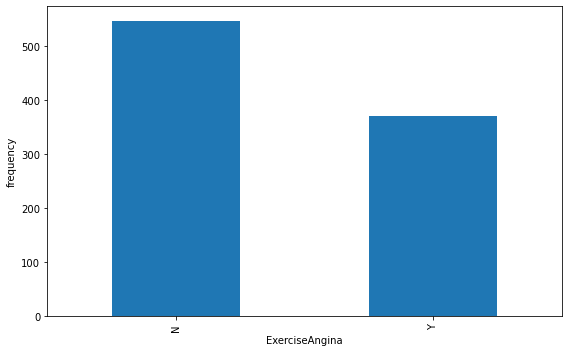

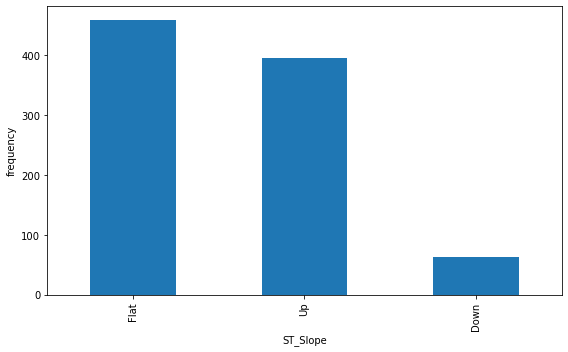

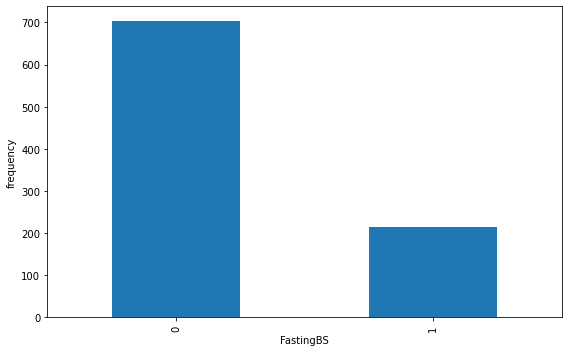

In [12]:
for cat in catFeatures:
    fig, ax = plt.subplots()
    df[cat].value_counts().plot(ax=ax, kind='bar', xlabel=cat, ylabel='frequency')
    plt.show()

In [13]:
for i in catFeatures:
    a=df[i].describe()
    print('Describe for '+ str(i))
    print(a)

Describe for Sex
count     917
unique      2
top         M
freq      724
Name: Sex, dtype: object
Describe for ChestPainType
count     917
unique      4
top       ASY
freq      496
Name: ChestPainType, dtype: object
Describe for RestingECG
count        917
unique         3
top       Normal
freq         551
Name: RestingECG, dtype: object
Describe for ExerciseAngina
count     917
unique      2
top         N
freq      546
Name: ExerciseAngina, dtype: object
Describe for ST_Slope
count      917
unique       3
top       Flat
freq       459
Name: ST_Slope, dtype: object
Describe for FastingBS
count    917.000000
mean       0.233370
std        0.423206
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: FastingBS, dtype: float64


In [14]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [15]:
#Compute Pearson pairwise correlation of features
corr_matrix=df[numFeatures].corr()
print(corr_matrix)

                  Age  RestingBP  Cholesterol     MaxHR   Oldpeak
Age          1.000000   0.263084    -0.095142 -0.382280  0.258563
RestingBP    0.263084   1.000000     0.089392 -0.109693  0.174252
Cholesterol -0.095142   0.089392     1.000000  0.237705  0.051390
MaxHR       -0.382280  -0.109693     0.237705  1.000000 -0.161213
Oldpeak      0.258563   0.174252     0.051390 -0.161213  1.000000


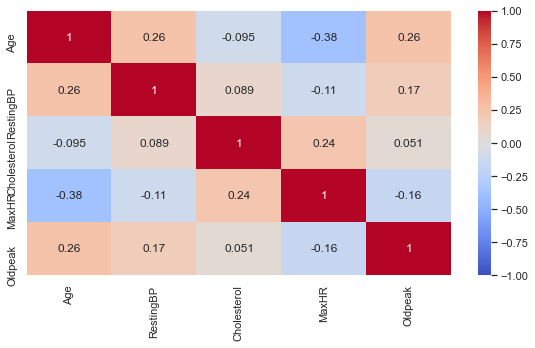

In [16]:
#Visualize Pearson pairwise correlation of features
fig = plt.figure()
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(corr_matrix,cmap='coolwarm', vmin=-1, vmax=1,annot = True)
plt.xticks(rotation=90)
ax.set_xticklabels(df[numFeatures].columns)
ax.set_yticklabels(df[numFeatures].columns)
plt.show()

In [ ]:
df_cluster = df[allFeatures]
df_cluster

In [ ]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA

df_new = pd.get_dummies(df_cluster, columns=catFeatures)

scaled = scale(df_new)
pca_model = PCA()
pca_model = pca_model.fit_transform(scaled)

pca_arr = []

for i in range(21):
    i = i + 1
    string = "PCA" + str(i)
    pca_arr.append(string)
    
df_pca = pd.DataFrame(pca_model, columns = pca_arr)

In [ ]:
from sklearn.cluster import KMeans
fig, ax1 = plt.subplots()

scaled = scale(df_new)

y_pred = KMeans(n_clusters = 2, init = 'random', max_iter = 5).fit_predict(scaled)
plt.scatter(scaled[:,0], scaled[:,1], c = y_pred, cmap = 'spring')


#for i,name in enumerate(df_cluster.index.values):
#    ax1.annotate(df_cluster.index[i], (scaled[i,0], scaled[i,1]), ha = 'center', fontsize = 5)
    
plt.show()

In [ ]:
ks = list(range(1,11))

scores = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit_predict(df_new)
    scores.append(-model.score(df_new))
    
plt.plot(ks,scores)
plt.ylabel('tital intra-cluster distance')
plt.xlabel('k')
plt.show()

In [ ]:
#maybe
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, resolution=0.02):
    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c=[cmap(idx)],
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)# plot decision regions for training set


plot_decision_regions(X_train_pca, y_train, classifier=lr)
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.legend(loc='lower left')
plt.show()

In [ ]:
numFeatures.append('HeartDisease')
numFeatures

In [ ]:
corr_matrix=df[numFeatures].corr()
print(corr_matrix)

In [ ]:
#Visualize Pearson pairwise correlation of features
fig = plt.figure()
sns.set(rc = {'figure.figsize':(15,8)})
ax = sns.heatmap(corr_matrix,cmap='coolwarm', vmin=-1, vmax=1,annot = True)
plt.xticks(rotation=90)
ax.set_xticklabels(df[numFeatures].columns)
ax.set_yticklabels(df[numFeatures].columns)
plt.show()

In [ ]:
#Remove Cholesterol variable
df = df.drop(labels = "Cholesterol", axis = 1)
df.head()

In [ ]:
allFeatures=df.columns[0:len(df.columns)-1]

catFeatures=[]
for i in range((len(df.columns)-1)):
    if df.dtypes[i]=='O':
        print(i)
        catFeatures.append(i)
catFeatures.append(4) #fasting bs is categorical 1: if FastingBS > 120 mg/dl, 0: otherwise

catFeatures=df.columns[catFeatures]
print(catFeatures)

numFeatures= [i for i in allFeatures if not(i in catFeatures)]
print(numFeatures)

In [ ]:
df[allFeatures]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[allFeatures], df["HeartDisease"], test_size=0.20, random_state=42)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[allFeatures], df["HeartDisease"], test_size = 0.2, random_state=42, stratify=df["HeartDisease"])

In [ ]:
y_df = pd.DataFrame(y_train)
count = 0
for i in range(len(y_df)):
    if (y_df.values[i].item() == 0):
        count = count + 1

count

In [ ]:
y_df = pd.DataFrame(y_test)
count = 0
for i in range(len(y_df)):
    if (y_df.values[i].item() == 0):
        count = count + 1

count

In [ ]:
328/len(y_train)

In [ ]:
82/len(y_test)

In [ ]:
len(X_train)

In [ ]:
train = pd.concat([X_train, y_train], axis=1)
train = train.reset_index(drop=True)
train

In [ ]:
# # 4. Using bootstrapping method, create 50 in-bag (training and validation) with the size of data, 
# # and related 50 out-of-bag or testing.
# samples_in_bag = []
# samples_out_bag = []
# # There are 733 total samples = 733 indicies
# indices = list(range(1, len(train[allFeatures])))

# for i in range(5): #FIXME CHANGE BACK TO 50
#     out_bag_indicies = []
#     if i == 0:
#         # all indices in the dataset
#         Index=range(0,int(len(train[allFeatures])))
#         # Resamples the array of indicies. Random state is needed for the first bootstrap to generate different 
#         # bootstraps
#         S1 = resample(Index, replace=True, n_samples=len(Index), random_state=1)
#         # appends to the samples in the array of in bags bootstraps
#         samples_in_bag.append(set(S1))
#     else:
#         # all indices in the dataset
#         Index=range(0,int(len(train[allFeatures])))
#         # Resamples the array of indicies.
#         S1 = resample(Index, replace=True, n_samples=len(Index))
#         # appends to the samples in the array of in bags bootstraps
#         samples_in_bag.append(set(S1))
        
#     # places the non-selected indicies into an out of bag bootstrap
#     # goes through all the indices
#     for j in range(len(indices)):
#         if indices[j] not in samples_in_bag[i]:
#             out_bag_indicies.append(j)
#     # appends to the array of out bags bootstraps
#     samples_out_bag.append(out_bag_indicies)
    
# # out of bag observations percentages of total data
# for i in range(5): #FIXME CHANGE BACK TO 50
#     print(len(samples_out_bag[i])/len(indices)*100.0) # out of bag 
#     # prints number of samples in one out of bag bootstrap, and prints number of samples in one in bag bootstrap
#     print(len(samples_out_bag[i]),len(samples_in_bag[i]))

In [ ]:
np.random.seed(1) #Set a random seed for reproducibility
inBags = [] 
outBags = []

for i in range(5): #Loop through 50 times to create 50 InBags/OutBags
    
    curInBag = sklearn.utils.resample(train, replace=True) #Creates a boot strap inBag the length of boston with replacement
    
    outBagRows = [] #to hold all of the rows not represented in the inBag
    for i in range(len(train)): 
        if i not in np.unique(list(curInBag.index)):  #Check to see if the row is not represented in the current in bag
            
            outBagRows.append(train.loc[i].to_frame().T) # When I select a row not in the in bag, it is a series
                                                           # I Use the .to_frame to convert the series to a DataFrame
                                                           # The data Frame is oriented the wrong way so the .T transposes it
    
    curOutBag = pd.concat(outBagRows) #This concatenates all of the out bag rows into one DF

    #This if statment checks to see if every row of boston is represnted between the cur inbag and the cur outbag
    if len(np.unique(list(curInBag.index))) + len(np.unique(list(curOutBag.index))) != len(train):
        print("ERROR! ALl of the unique values should be represented")

    #Add the inbag/outBag to their respective lists
    inBags.append(curInBag)
    outBags.append(curOutBag)

In [ ]:
inBags[0].columns

In [ ]:
scaler = StandardScaler() #Creates a SKlearn standard Scaler object

for i in range(len(inBags)): #Loop through each of the inBags
    
    #STANDARD SCALER
    scaler.fit(inBags[i][numFeatures]) #Transforms inBags
    inBags[i][numFeatures]=scaler.transform(inBags[i][numFeatures])

    scaler.fit(outBags[i][numFeatures]) #Transforms outBags
    outBags[i][numFeatures]=scaler.transform(outBags[i][numFeatures])
    
    #ENCODE CATEGORICAL VARIABLES
    from sklearn import preprocessing
#     enc = OneHotEncoder(sparse=False)
#     inBags[i] = enc.fit_transform(inBags[i][catFeatures]])
    
    inBags[i] = pd.get_dummies(inBags[i], columns=catFeatures)  #Transform inBags
    outBags[i] = pd.get_dummies(outBags[i], columns=catFeatures)  #Transform outBags


#     le = preprocessing.LabelEncoder()
#     le.fit_transform(inBags[i][xFeatures])

In [ ]:
xFeatures = inBags[0].columns.tolist()
xFeatures.remove('HeartDisease')
yFeatures = ['HeartDisease']

#catFeatures
inBags[0][xFeatures]

In [ ]:
# # Use sklearn StandardScaler to scale numeric features
# # Standardized features by removing the mean and scaling to unit variance
# array_of_pds_train = []
# array_of_pds_test = []
# train_y_arr = []
# test_y_arr = []

# for i in range(len(samples_in_bag)):
#     # get the one in bag bootstrap and one out of bag bootstrap
#     sample_in = samples_in_bag[i]
#     sample_out = samples_out_bag[i]

#     # create scalor object
#     scalor=StandardScaler()
    
#     # select the subset from data that corresponds to specific in bag bootstrap
#     df_train = train[numFeatures].loc[sample_in, :]
#     # select the subset from data that corresponds to specific out of bag bootstrap
#     df_test = train[numFeatures].loc[sample_out, :]
#     # select the subset of the categorical variable that corresponds to specific in bag Bootstrap 
#     df_train_char = train[catFeatures].loc[sample_in]
#     df_train_char = df_train_char.reset_index(drop=True)
#     # select the subset of the categorical variable that corresponds to specific out of bag Bootstrap 
#     df_test_char = train[catFeatures].loc[sample_out]
#     df_test_char = df_test_char.reset_index(drop = True)
#     # select the subset of the target that corresponds to specific in bag bootstrap
#     train_y = train['HeartDisease'].loc[sample_in].to_numpy()
#     # select the subset of the target that corresponds to specific out of bag bootstrap
#     test_y = train['HeartDisease'].loc[sample_out].to_numpy()
    
#     # Computes the mean and std of the data
#     scalor.fit(df_train)
#     # Performs standardization on the training set and testing set
#     df_train=scalor.transform(df_train)
#     df_test=scalor.transform(df_test)
#     #places resulting values into a dataframe
#     df_train = pd.DataFrame(df_train, columns=numFeatures)
#     df_test = pd.DataFrame(df_test, columns=numFeatures)
    
#     # attach the categorical variables to the dataframes
#     df_train_allF = pd.concat([df_train, df_train_char], axis=1)
#     df_test_allF = pd.concat([df_test, df_test_char], axis = 1)
#     #df_train[catFeatures] = df_train_char
#     #df_test[catFeatures] = df_test_char
    
#     # creates an array of training dataframes that have subsets from each bootstrap
#     array_of_pds_train.append(df_train_allF)
#     # creates an array of testing dataframes that have subsets from each bootstrap
#     array_of_pds_test.append(df_test_allF)
#     # creates an array of y values for the training data that have subsets from each bootstrap
#     train_y_arr.append(train_y)
#     # creates an array of y values for the testing data that have subsets from each bootstrap
#     test_y_arr.append(test_y) 

In [ ]:
# # Encode all possible categorical data using get_dummies
# for i in range(len(array_of_pds_train)):
#     array_of_pds_train[i] = pd.get_dummies(array_of_pds_train[i])
#     array_of_pds_test[i] = pd.get_dummies(array_of_pds_test[i])

# array_of_pds_test[2]

In [ ]:
cv_inner = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

model_rf=RandomForestClassifier(random_state=1)
rf_pipeline = Pipeline([ 
    #('pca', PCA()), 
    ('model_rf',model_rf)
])
rf_param = {
               #'pca__n_components': [0.60,0.70,0.80,0.90],
               'model_rf__bootstrap': [True, False],
               'model_rf__max_depth': [2, 3, 5, 7, 9],
               'model_rf__max_features': [10],
               'model_rf__n_estimators': [10, 100, 500]} 

rf_random = RandomizedSearchCV(rf_pipeline, rf_param, cv=cv_inner, scoring='f1')

In [ ]:
rfModels = []
rfScores = []

# for i in range(len(samples_in_bag)):
#     model = rf_random.fit(array_of_pds_train[i], np.asarray(df.loc[samples_in_bag[i]]["HeartDisease"].squeeze().tolist()))
#     rfModels.append(model)
#     curScore = f1_score(df.loc[samples_out_bag[i]]["HeartDisease"], model.predict(array_of_pds_test[i]))
#     rfScores.append(curScore)


for i in range(len(inBags)):
    model = rf_random.fit(inBags[i][xFeatures], np.asarray(inBags[i][yFeatures].squeeze().tolist()))
    rfModels.append(model)
    curScore = f1_score(outBags[i][yFeatures].squeeze().tolist(), model.predict(outBags[i][xFeatures]))
    rfScores.append(curScore)


In [ ]:
topScore = max(rfScores)
topModel = rfModels[0]
for i in range(len(rfScores)):
    if rfScores[i] == topScore:
        topModel = rfModels[i]
bestModel = topModel.best_estimator_.named_steps["model_rf"]


In [ ]:
topScore = max(rfScores)
topModel = rfModels[0]
for i in range(len(rfScores)):
    if rfScores[i] == topScore:
        topModel = rfModels[i]
        
bestModel = topModel.best_estimator_.named_steps["model_rf"]
importances = bestModel.feature_importances_
forest_importances = pd.Series(importances, index=xFeatures)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [ ]:
model_xgb = xgb.XGBClassifier(random_state=1,objective='binary:logistic',eval_metric='logloss',use_label_encoder=False)
xgb_pipeline = Pipeline([
    ('model_xgb', model_xgb)
])

xgb_param= {
    'model_xgb__max_depth': [2, 3, 5,7,9],
    'model_xgb__n_estimators': [10, 100, 500]}
xgb_random = RandomizedSearchCV(xgb_pipeline, xgb_param, cv=cv_inner, scoring='f1')

In [ ]:
xgbModels = []
xgbScores = []

for i in range(len(inBags)):
    model = xgb_random.fit(inBags[i][xFeatures], np.asarray(inBags[i][yFeatures].squeeze().tolist()))
    xgbModels.append(model)
    curScore = f1_score(outBags[i][yFeatures].squeeze().tolist(), model.predict(outBags[i][xFeatures]))
    xgbScores.append(curScore)

In [ ]:
from xgboost import plot_importance 

topScore = max(xgbScores)
topModel = xgbModels[0]
for i in range(len(xgbModels)):
    if xgbScores[i] == topScore:
        topModel = xgbModels[i]

bestModel = topModel.best_estimator_.named_steps["model_xgb"]

plot_importance(bestModel)

In [ ]:
from sklearn import svm


model_svm=svm.SVC()
svm_pipeline = Pipeline([ 
    ('model_svm',model_svm)
])
svm_param = {
               'model_svm__kernel': ['linear'],
               'model_svm__gamma': ['scale', 'auto'],
               'model_svm__C': [.1, .5, 1, 1.5, 2]}

svm_random = RandomizedSearchCV(svm_pipeline, svm_param, cv=cv_inner, scoring='f1', random_state=42)

In [ ]:
svmModels = []
svmScores = []

for i in range(len(inBags)):
    model = svm_random.fit(inBags[i][xFeatures], np.asarray(inBags[i][yFeatures].squeeze().tolist()))
    svmModels.append(model)
    curScore = f1_score(outBags[i][yFeatures].squeeze().tolist(), model.predict(outBags[i][xFeatures]))
    svmScores.append(curScore)

In [ ]:
topScore = max(svmScores)
topModel = svmModels[0]
for i in range(len(svmScores)):
    if svmScores[i] == topScore:
        topModel = svmModels[i]
        
bestModel = topModel.best_estimator_.named_steps["model_svm"]

importances = bestModel.coef_

forest_importances = pd.Series(importances[0], index=xFeatures)
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
fig.tight_layout()

In [ ]:
#Friedman
stats.friedmanchisquare(svmScores,xgbScores,rfScores) #Gets the Friedman statistic

In [ ]:
trans_groups=np.array([KNNScores,LinRegScores,DTScores,SVMScores,RandomForestScores]).T #Merges all the scores into one dataframe 
posthoc_nemenyi_friedman(trans_groups) #Gets the pairwise comparison of all the scores. 


In [ ]:
#**********************
#        todo
#**********************

#one-hot-encoding (Sam)
#Some clustering algorithm for exploring the data (KNN) (Marko)
#Shap (Nidhi)
#add another evaluation metric (not f1) (Nidhi)
#add another ML algorithm that we haven't done in class (Sam)
#comment and clean code. (Marko)